In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from fit_models_colossus import Delta_Sigma_fit
from fit_models_colossus import Delta_Sigma_NFW_2h

Load profile
- First we are going to load density contrast profile for redMaPPer clusters. The profile is obtained by averaging the tangential component of the source galaxies, selected from the CFHTLens catalogue. It is computed using 20 logharitmic radial bins from 300 h^{-1}kpc up to 1h^{-1}Mpc

In [2]:
profile_rM = fits.open('profile_redmapper.fits')[1]
p          = profile_rM.data

Let's take a look at the header

In [3]:
profile_rM.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =                   20 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'Rp      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DSigma_T'                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'error_DSigma_T'  

It contains the stacked signal of 204 galaxy clusters, selected from the redmapper v6.3 catalog based on the SDSS DR8 database. The clusters are selected to match the sky regions that overlaps CFHTLens catalg, with a redshift range 0.1 < z < 0.4 and with a richness range 20 < lambda < 150. The mean redshift of the clusters it's given by Z_MEAN. We are going to save it as a variable:

In [4]:
zmean = profile_rM.header['Z_MEAN']

- Let's look how the profile looks like by making a plot

Text(0.5, 0, '$R [Mpc/h]$')

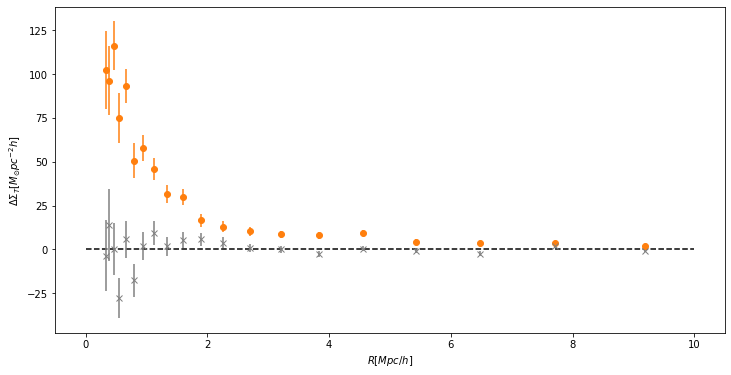

In [5]:
plt.subplots(figsize=(12,6))
plt.plot([0,10],[0,0],'k--')
plt.errorbar(p.Rp,p.DSigma_T,yerr=p.error_DSigma_T,fmt='C1o')
plt.errorbar(p.Rp,p.DSigma_X,yerr=p.error_DSigma_X,fmt='C7x')
plt.ylabel(r'$\Delta\Sigma_{T} [M_{\odot}pc^{-2} h ]$')
plt.xlabel(r'$R [Mpc/h]$')


Red points correspond to the average tangential component and corresponds to the density contrast at each radial bin, while the grey crosses are computed averaging the cross component and should be compatible with a null profile. It look's nice! Great signal! Take into account that you are looking at the mean cluster density distribution through the shape distortion of background galaxies :)

- Now, we can try to fit the density contrast profile with an NFW model to get the mass. We need to run Delta_Sigma_fit with takes as input the tangential shear profile, with the errors (obtained by bootstraping the source galaxies) and the mean redshift. In order to neglect the contribution of the neighbouring mass distribution (the 2-halo term), we are going to use only the data up to 3Mpc. Let's try it!

In [6]:
NFW = Delta_Sigma_fit(p.Rp,p.DSigma_T,p.error_DSigma_T,zmean,ROUT=3)
print('Fitted parameters...')
print('M_200 = ',NFW.M200/1.e14,'x 10^14 M_sun')
print('c_200 = ',NFW.c200)
print(r'$\chi^2 = $',NFW.chi2)
print(len(NFW.xplot))

Fitted parameters...
M_200 =  1.4148942126093484 x 10^14 M_sun
c_200 =  3.4738436849357495
$\chi^2 = $ 1.4694119946442505
20


We can see how it looks the fit

(-30.0, 35.0)

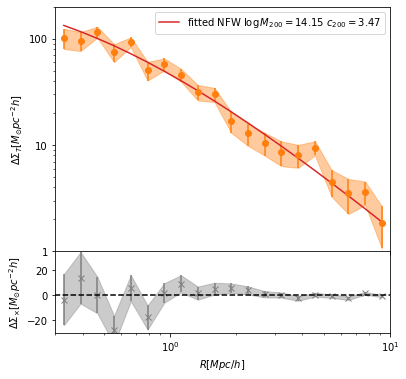

In [7]:
    mass = str(np.round(np.log10(NFW.M200),2))
    cfit = str(np.round(NFW.c200,2))
    
    f, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(6,6),sharex = True)
    f.subplots_adjust(hspace=0)
                    

    ax[0].errorbar(p.Rp,p.DSigma_T,yerr=p.error_DSigma_T,ecolor='C1',fmt='C1o')
    ax[0].plot(NFW.xplot,NFW.yplot,'C3',label='fitted NFW $\log M_{200}=$'+mass+' $c_{200} = $'+cfit)
    ax[0].fill_between(p.Rp,p.DSigma_T+p.error_DSigma_T,p.DSigma_T-p.error_DSigma_T,color='C1',alpha=0.4)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\Delta\Sigma_{T} [M_{\odot}pc^{-2} h ]$')
    ax[0].set_ylim(1,200)
    ax[0].set_xlim(0.3,10)
    ax[0].yaxis.set_ticks([1,10,100])
    ax[0].set_yticklabels([1,10,100])
    ax[0].legend()

    ax[1].plot(p.Rp,p.DSigma_X,'C7x')
    ax[1].errorbar(p.Rp,p.DSigma_X,yerr=p.error_DSigma_X,ecolor='C7',fmt='None')
    ax[1].fill_between(p.Rp,p.DSigma_X+p.error_DSigma_X,p.DSigma_X-p.error_DSigma_X,color='C7',alpha=0.4)
    ax[1].set_ylabel(r'$\Delta\Sigma_{\times} [M_{\odot}pc^{-2} h ]$')
    ax[1].set_xlabel(r'$R [Mpc/h]$')
    ax[1].plot([0,10],[0,0],'k--')
    ax[1].set_ylim(-30,35)


It looks ok... but it could be better. In particular there is a depletion of the signal at lower distances. This could be related by a bad centre definition. We are going load the other profile that considers only the clusters where the brightest galaxy has a probability higher than 0.9 of being located at the halo centre. 

In [8]:
profile_rMc = fits.open('profile_redmapper_centred.fits')[1]
pc          = profile_rMc.data

- Try fitting this new profile

In [9]:
NFW_c = Delta_Sigma_fit(pc.Rp,pc.DSigma_T,pc.error_DSigma_T,zmean,ROUT=3.)
print('Fitted parameters...')
print('M_200 = ',NFW_c.M200/1.e14,'x 10^14 M_sun')
print('c_200 = ',NFW_c.c200)
print(r'$\chi^2 = $',NFW_c.chi2)

Fitted parameters...
M_200 =  1.5258407810324452 x 10^14 M_sun
c_200 =  3.7169132771622806
$\chi^2 = $ 0.7249644402743308


Both mass and concentrations are higher

- Now plot both profiles together to see the differences

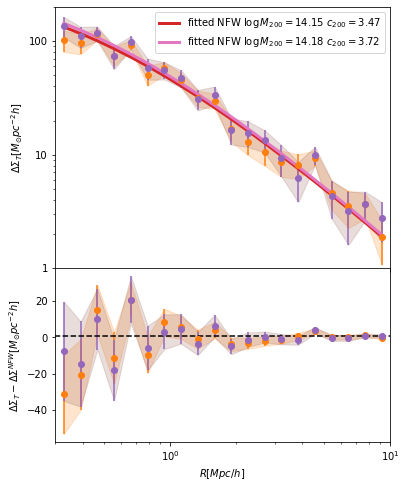

In [10]:
    mass_c = str(np.round(np.log10(NFW_c.M200),2))
    cfit_c = str(np.round(NFW_c.c200,2))
    
    f, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]},figsize=(6,8),sharex = True)
    f.subplots_adjust(hspace=0)
                    
    ax[0].errorbar(p.Rp,p.DSigma_T,yerr=p.error_DSigma_T,ecolor='C1',fmt='C1o')
    ax[0].errorbar(pc.Rp,pc.DSigma_T,yerr=pc.error_DSigma_T,ecolor='C4',fmt='C4o')
    ax[0].plot(NFW.xplot,NFW.yplot,'C3',label='fitted NFW $\log M_{200}=$'+mass+' $c_{200} = $'+cfit,lw=3)
    ax[0].plot(NFW_c.xplot,NFW_c.yplot,'C6',label='fitted NFW $\log M_{200}=$'+mass_c+' $c_{200} = $'+cfit_c,lw=3)
    ax[0].fill_between(p.Rp,p.DSigma_T+p.error_DSigma_T,p.DSigma_T-p.error_DSigma_T,color='C1',alpha=0.2)
    ax[0].fill_between(pc.Rp,pc.DSigma_T+pc.error_DSigma_T,pc.DSigma_T-pc.error_DSigma_T,color='C5',alpha=0.2)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$\Delta\Sigma_{T} [M_{\odot}pc^{-2} h ]$')
    ax[0].set_ylim(1,200)
    ax[0].set_xlim(0.3,10)
    ax[0].yaxis.set_ticks([1,10,100])
    ax[0].set_yticklabels([1,10,100])
    ax[0].legend()
    
    ax[1].errorbar(p.Rp,p.DSigma_T-NFW.yplot,yerr=p.error_DSigma_T,ecolor='C1',fmt='C1o')
    ax[1].errorbar(pc.Rp,pc.DSigma_T-NFW_c.yplot,yerr=pc.error_DSigma_T,ecolor='C4',fmt='C4o')
    ax[1].fill_between(p.Rp,(p.DSigma_T+p.error_DSigma_T)-NFW.yplot,(p.DSigma_T-p.error_DSigma_T)-NFW.yplot,color='C1',alpha=0.2)
    ax[1].fill_between(pc.Rp,(pc.DSigma_T+pc.error_DSigma_T)-NFW_c.yplot,(pc.DSigma_T-pc.error_DSigma_T)-NFW_c.yplot,color='C5',alpha=0.2)
    ax[1].set_ylabel(r'$\Delta\Sigma_{T} - \Delta\Sigma^{NFW} [M_{\odot}pc^{-2} h ]$')
    ax[1].set_xlabel(r'$R [Mpc/h]$')
    ax[1].plot([0,10],[1,1],'k--')
    



In the above panel you can notice the differences between the fitting and model.

In [20]:
DS1h = Delta_Sigma_NFW_2h(pc.Rp,zmean,NFW_c.M200*0.97,NFW_c.c200,terms='1h')
DS2h = Delta_Sigma_NFW_2h(pc.Rp,zmean,NFW_c.M200*0.97,NFW_c.c200,terms='2h')
print(DS1h)

[141.33326854 123.11531525 105.87474643  89.9085891   75.42515619
  62.54095917  51.28726779  41.62349484  33.45425503  26.64716797
  21.04923028  16.50043152  12.84406837   9.933806     7.6378998
   5.8411486    4.44519614   3.36772419   2.54098853   1.91003522]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


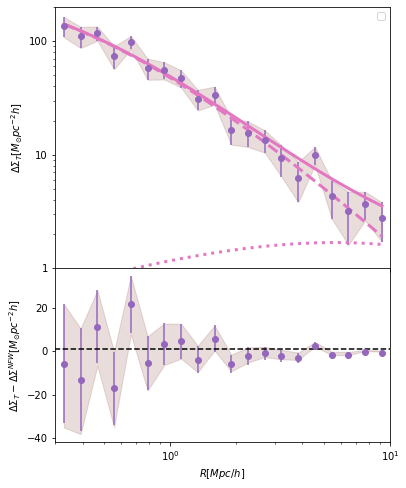

In [21]:
mass_c = str(np.round(np.log10(NFW_c.M200),2))
cfit_c = str(np.round(NFW_c.c200,2))
    
f, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]},figsize=(6,8),sharex = True)
f.subplots_adjust(hspace=0)
                    

ax[0].errorbar(pc.Rp,pc.DSigma_T,yerr=pc.error_DSigma_T,ecolor='C4',fmt='C4o')
ax[0].plot(pc.Rp,DS1h,'C6--',lw=3)
ax[0].plot(pc.Rp,DS2h,'C6:',lw=3)
ax[0].plot(pc.Rp,DS1h+DS2h,'C6',lw=3)
ax[0].fill_between(pc.Rp,pc.DSigma_T+pc.error_DSigma_T,pc.DSigma_T-pc.error_DSigma_T,color='C5',alpha=0.2)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\Delta\Sigma_{T} [M_{\odot}pc^{-2} h ]$')
ax[0].set_ylim(1,200)
ax[0].set_xlim(0.3,10)
ax[0].yaxis.set_ticks([1,10,100])
ax[0].set_yticklabels([1,10,100])
ax[0].legend()
    
ax[1].errorbar(pc.Rp,pc.DSigma_T-(DS1h+DS2h),yerr=pc.error_DSigma_T,ecolor='C4',fmt='C4o')
ax[1].fill_between(pc.Rp,(pc.DSigma_T+pc.error_DSigma_T)-(DS1h+DS2h),(pc.DSigma_T-pc.error_DSigma_T)-NFW_c.yplot,color='C5',alpha=0.2)
ax[1].set_ylabel(r'$\Delta\Sigma_{T} - \Delta\Sigma^{NFW} [M_{\odot}pc^{-2} h ]$')
ax[1].set_xlabel(r'$R [Mpc/h]$')
ax[1].plot([0,10],[1,1],'k--')
    

